In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from pathlib import Path
from typing import Dict, List, Any
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


Model Performance Comparison Notebook


In [2]:

# =============================================================================
# MODEL NAME MAPPING - EDIT THIS SECTION TO RENAME MODELS FOR CLEANER GRAPHS
# =============================================================================

# Map provider/model combinations to display names for cleaner visualization
model_name_mapping = {
    # Add mappings in format: "provider/model": "Display Name"
    "lm-studio/unsloth/qwen3-235b-a22b": "qwen3-235b-a22b",
    "lm-studio/deepseek-r1-0528-distill-qwen3-32b-preview0-qat@q4_k_m": "Deepseek-qwen3-32B",
    "lm-studio/unsloth/qwen3-30b-a3b": "qwen3-30b-a3b",
    "lm-studio/josiefied-deepseek-r1-0528-qwen3-8b-abliterated-v1": "Deepseek-qwen3-8B",
    "lm-studio/unsloth/qwen3-14b": "qwen3-14b",
    "openai/gpt-4.1-mini": "gpt-4.1-mini", 
    "openai/gpt-4.1": "gpt-4.1",
    # Add more mappings as needed...
}

# Custom colors for specific models (optional)
model_colors = {
    "qwen3-235b-a22b": "#FF6B6B",      # Red
    "Deepseek-qwen3-32B": "#4ECDC4",   # Teal
    "qwen3-30b-a3b": "#45B7D1",        # Blue
    "Deepseek-qwen3-8B": "#96CEB4",    # Green
    "qwen3-14b": "#FF9F1C",            # Orange
    "gpt-4.1-mini": "#7209B7",         # Purple
    "gpt-4.1": "#3A0CA3",              # Deep Blue
    # Add more color mappings as needed...
}

# Function to get display name
def get_display_name(provider, model):
    key = f"{provider}/{model}"
    return model_name_mapping.get(key, f"{provider}/{model}")

print("Model name mapping configured!")
print("Available mappings:")
for key, value in model_name_mapping.items():
    print(f"  {key} → {value}")


Model name mapping configured!
Available mappings:
  lm-studio/unsloth/qwen3-235b-a22b → qwen3-235b-a22b
  lm-studio/deepseek-r1-0528-distill-qwen3-32b-preview0-qat@q4_k_m → Deepseek-qwen3-32B
  lm-studio/unsloth/qwen3-30b-a3b → qwen3-30b-a3b
  lm-studio/josiefied-deepseek-r1-0528-qwen3-8b-abliterated-v1 → Deepseek-qwen3-8B
  lm-studio/unsloth/qwen3-14b → qwen3-14b
  openai/gpt-4.1-mini → gpt-4.1-mini
  openai/gpt-4.1 → gpt-4.1


In [3]:
# Find all result directories
results_base_dir = Path("results/unified_error_dataset")
timestamp_dirs = [d for d in results_base_dir.iterdir() if d.is_dir()]

print(f"Found {len(timestamp_dirs)} evaluation result directories:")
for dir_path in sorted(timestamp_dirs):
    print(f"  {dir_path.name}")

# ============================================================================
# BIAS MITIGATION: Identify data points that failed across models
# ============================================================================

print(f"\nANALYZING PROCESSING FAILURES TO ENSURE FAIR COMPARISON...")

model_failures = {}
model_detailed_data = {}

for timestamp_dir in timestamp_dirs:
    detailed_file = timestamp_dir / "detailed_results.csv"
    info_file = timestamp_dir / "evaluation_info.json"
    
    if detailed_file.exists() and info_file.exists():
        try:
            # Read model info
            with open(info_file, 'r') as f:
                info_data = json.load(f)
            
            provider = info_data['evaluation_config']['provider']
            model = info_data['evaluation_config']['model']
            display_name = get_display_name(provider, model)
            
            # Read detailed results
            detailed_df = pd.read_csv(detailed_file)
            
            # Find failed predictions (null predicted_label)
            failed_records = detailed_df[detailed_df['predicted_label'].isnull()]
            failed_ids = set(failed_records['id'].tolist()) if len(failed_records) > 0 else set()
            
            model_failures[display_name] = failed_ids
            model_detailed_data[display_name] = detailed_df
            
            print(f"  {display_name}: {len(failed_ids)} failures out of {len(detailed_df)} total")
            
        except Exception as e:
            print(f"  Error analyzing {timestamp_dir.name}: {str(e)}")

# Find data points successfully processed by ALL models
all_failed_ids = set()
for failed_ids in model_failures.values():
    all_failed_ids.update(failed_ids)

# Get IDs that were successfully processed by ALL models
all_possible_ids = set(range(1, 2541))  # Based on dataset info
safe_comparison_ids = all_possible_ids - all_failed_ids

print(f"\nFAIR COMPARISON ANALYSIS:")
print(f"  Total data points in dataset: {len(all_possible_ids)}")
print(f"  Data points that failed in at least one model: {len(all_failed_ids)}")
print(f"  Data points successfully processed by ALL models: {len(safe_comparison_ids)}")
print(f"  Fair comparison dataset size: {len(safe_comparison_ids)} records ({len(safe_comparison_ids)/len(all_possible_ids):.1%})")

# Load all evaluation metrics
all_metrics = []

for timestamp_dir in timestamp_dirs:
    metrics_file = timestamp_dir / "evaluation_metrics.csv"
    info_file = timestamp_dir / "evaluation_info.json"
    
    if metrics_file.exists() and info_file.exists():
        try:
            # Read metrics CSV
            metrics_df = pd.read_csv(metrics_file)
            
            # Read additional info from JSON
            with open(info_file, 'r') as f:
                info_data = json.load(f)
            
            # Extract model info
            provider = info_data['evaluation_config']['provider']
            model = info_data['evaluation_config']['model']
            
            # Get display name
            display_name = get_display_name(provider, model)
            
            # Add to metrics
            for _, row in metrics_df.iterrows():
                model_data = row.to_dict()
                model_data['display_name'] = display_name
                model_data['original_provider'] = provider
                model_data['original_model'] = model
                all_metrics.append(model_data)
            
            print(f"Loaded: {timestamp_dir.name} - {display_name}")
            
        except Exception as e:
            print(f"Error loading {timestamp_dir.name}: {str(e)}")
    else:
        print(f"Missing files in {timestamp_dir.name}")

print(f"\nSuccessfully loaded {len(all_metrics)} model evaluations")


Found 7 evaluation result directories:
  20250616_054144
  20250616_054323
  20250616_054821
  20250616_060223
  20250616_085241
  20250616_085446
  20250616_094702

ANALYZING PROCESSING FAILURES TO ENSURE FAIR COMPARISON...
  gpt-4.1-mini: 0 failures out of 2540 total
  gpt-4.1: 1 failures out of 2540 total
  qwen3-30b-a3b: 100 failures out of 2540 total
  qwen3-235b-a22b: 72 failures out of 2540 total
  Deepseek-qwen3-32B: 100 failures out of 2540 total
  Deepseek-qwen3-8B: 100 failures out of 2540 total
  qwen3-14b: 100 failures out of 2540 total

FAIR COMPARISON ANALYSIS:
  Total data points in dataset: 2540
  Data points that failed in at least one model: 101
  Data points successfully processed by ALL models: 2439
  Fair comparison dataset size: 2439 records (96.0%)
Loaded: 20250616_085446 - gpt-4.1-mini
Loaded: 20250616_060223 - gpt-4.1
Loaded: 20250616_054144 - qwen3-30b-a3b
Loaded: 20250616_094702 - qwen3-235b-a22b
Loaded: 20250616_085241 - Deepseek-qwen3-32B
Loaded: 20250616_

In [4]:
if all_metrics:
    # Create DataFrame from all metrics
    df_metrics = pd.DataFrame(all_metrics)
    
    # Handle duplicate models (take the most recent)
    df_metrics = df_metrics.sort_values('timestamp').drop_duplicates(
        subset=['display_name'], keep='last'
    ).reset_index(drop=True)
    
    # =======================================================================
    # CALCULATE FAIR COMPARISON METRICS (only on successfully processed data)
    # =======================================================================
    
    fair_comparison_metrics = []
    
    print(f"\n CALCULATING FAIR COMPARISON METRICS...")
    print("=" * 60)
    
    for model_name, detailed_df in model_detailed_data.items():
        # Filter to only include data points successfully processed by ALL models
        fair_df = detailed_df[detailed_df['id'].isin(safe_comparison_ids)].copy()
        
        # Remove any remaining null predictions (should be none, but safety check)
        fair_df = fair_df[fair_df['predicted_label'].notnull()]
        
        if len(fair_df) > 0:
            # Calculate metrics on fair comparison data
            correct_predictions = fair_df['is_correct'].sum()
            total_predictions = len(fair_df)
            accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
            
            # Confusion matrix components
            tp = len(fair_df[(fair_df['actual_label'] == 1) & (fair_df['predicted_label'] == 1)])
            tn = len(fair_df[(fair_df['actual_label'] == 0) & (fair_df['predicted_label'] == 0)])
            fp = len(fair_df[(fair_df['actual_label'] == 0) & (fair_df['predicted_label'] == 1)])
            fn = len(fair_df[(fair_df['actual_label'] == 1) & (fair_df['predicted_label'] == 0)])
            
            # Calculate metrics
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            fair_comparison_metrics.append({
                'Model': model_name,
                'Fair_Accuracy': accuracy,
                'Fair_Precision': precision,
                'Fair_Recall': recall,
                'Fair_F1_Score': f1_score,
                'Fair_Specificity': specificity,
                'Fair_Dataset_Size': total_predictions,
                'Fair_Correct': correct_predictions,
                'Fair_TP': tp,
                'Fair_TN': tn,
                'Fair_FP': fp,
                'Fair_FN': fn
            })
            
            print(f"{model_name}: {total_predictions} records, Accuracy: {accuracy:.3f}, F1: {f1_score:.3f}")
        else:
            print(f"{model_name}: No valid data for fair comparison")
    
    # Create summary tables
    summary_cols = [
        'display_name', 'accuracy', 'precision', 'recall', 'f1_score', 
        'specificity', 'successfully_processed', 'failed_predictions'
    ]
    
    summary_df = df_metrics[summary_cols].copy()
    summary_df = summary_df.rename(columns={
        'display_name': 'Model',
        'accuracy': 'Accuracy',
        'precision': 'Precision', 
        'recall': 'Recall',
        'f1_score': 'F1 Score',
        'specificity': 'Specificity',
        'successfully_processed': 'Processed',
        'failed_predictions': 'Failed'
    })
    
    # Create fair comparison summary
    fair_summary_df = pd.DataFrame(fair_comparison_metrics) if fair_comparison_metrics else pd.DataFrame()
    
    if not fair_summary_df.empty:
        fair_summary_df = fair_summary_df.sort_values('Fair_F1_Score', ascending=False).reset_index(drop=True)
    
    # Sort original by F1 Score
    summary_df = summary_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)
    
    print(f"\n ORIGINAL METRICS (All Attempted Data)")
    print("=" * 60)
    print(summary_df.round(4))
    
    if not fair_summary_df.empty:
        print(f"\n FAIR COMPARISON METRICS (Only Successfully Processed Data)")
        print("=" * 60)
        fair_display = fair_summary_df[['Model', 'Fair_Accuracy', 'Fair_Precision', 'Fair_Recall', 'Fair_F1_Score', 'Fair_Specificity', 'Fair_Dataset_Size']].copy()
        fair_display.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'Dataset Size']
        print(fair_display.round(4))
        
        # Compare rankings
        print(f"\n RANKING COMPARISON:")
        if len(summary_df) == len(fair_display):
            print("Original Ranking vs Fair Comparison Ranking:")
            for i in range(len(summary_df)):
                orig_model = summary_df.iloc[i]['Model']
                fair_model = fair_display.iloc[i]['Model']
                if orig_model != fair_model:
                    print(f"  Rank {i+1}: {orig_model} → {fair_model} CHANGED")
                else:
                    print(f"  Rank {i+1}: {orig_model} ✓")
    
    # Dataset info
    print(f"\n Dataset Information:")
    if not df_metrics.empty:
        sample_record = df_metrics.iloc[0]
        print(f"Total Records: {sample_record['total_records_in_dataset']:,}")
        print(f"Scam: {sample_record['scam_count_in_dataset']:,}")
        print(f"Legitimate: {sample_record['legitimate_count_in_dataset']:,}")
        print(f"Fair Comparison Size: {len(safe_comparison_ids):,} records")
        
else:
    print("No metrics data available.")
    summary_df = pd.DataFrame()
    fair_summary_df = pd.DataFrame()



 CALCULATING FAIR COMPARISON METRICS...
gpt-4.1-mini: 2439 records, Accuracy: 0.713, F1: 0.752
gpt-4.1: 2439 records, Accuracy: 0.703, F1: 0.693
qwen3-30b-a3b: 2439 records, Accuracy: 0.408, F1: 0.423
qwen3-235b-a22b: 2439 records, Accuracy: 0.625, F1: 0.648
Deepseek-qwen3-32B: 2439 records, Accuracy: 0.533, F1: 0.645
Deepseek-qwen3-8B: 2439 records, Accuracy: 0.378, F1: 0.159
qwen3-14b: 2439 records, Accuracy: 0.544, F1: 0.461

 ORIGINAL METRICS (All Attempted Data)
                Model  Accuracy  Precision  Recall  F1 Score  Specificity  \
0        gpt-4.1-mini    0.7193     0.7820  0.7204    0.7499       0.7178   
1             gpt-4.1    0.7105     0.9174  0.5543    0.6910       0.9299   
2     qwen3-235b-a22b    0.6268     0.7456  0.5714    0.6470       0.7094   
3  Deepseek-qwen3-32B    0.5332     0.5955  0.7036    0.6451       0.2745   
4           qwen3-14b    0.5443     0.8027  0.3236    0.4612       0.8793   
5       qwen3-30b-a3b    0.4082     0.5130  0.3610    0.4238     

## Performance Visualizations


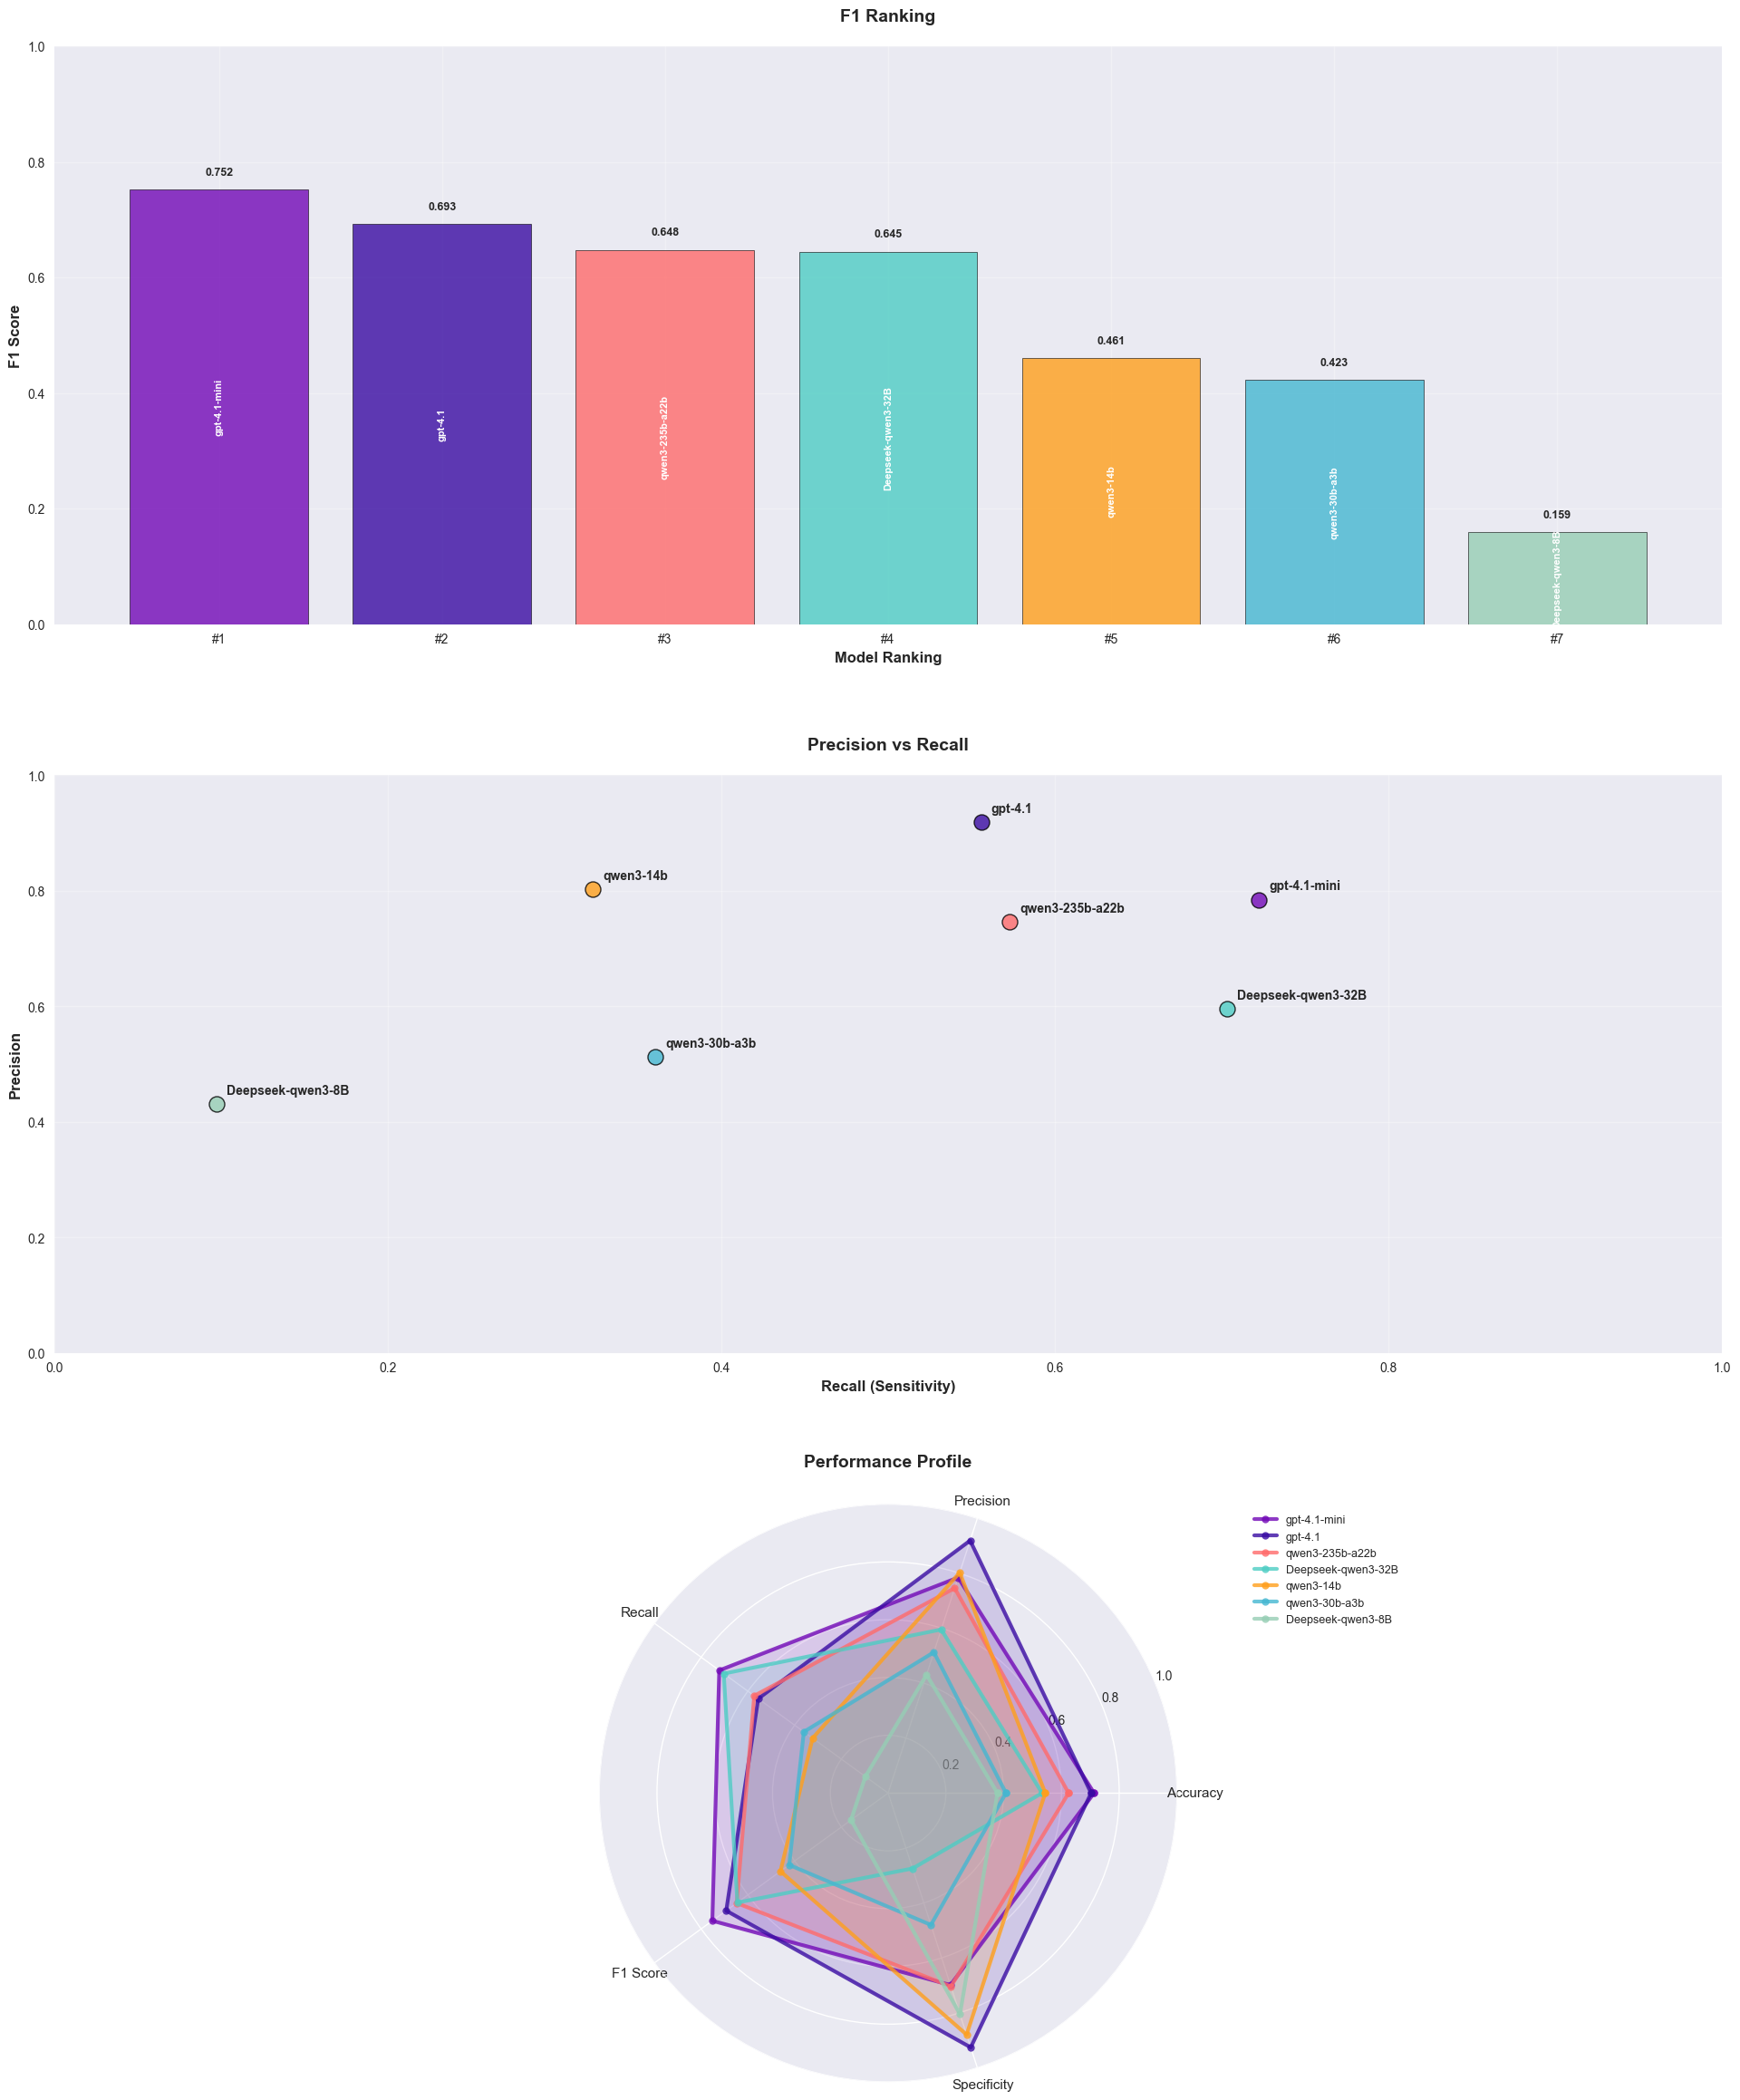

In [5]:
if not summary_df.empty and not fair_summary_df.empty:
    # Set up colors
    color_map = {}
    for model in summary_df['Model']:
        if model in model_colors:
            color_map[model] = model_colors[model]
    
    # If no custom colors, use default palette
    if not color_map:
        colors = sns.color_palette("husl", len(summary_df))
        color_map = dict(zip(summary_df['Model'], colors))
    
    # Prepare fair comparison data with consistent column names
    fair_display_df = fair_summary_df[['Model', 'Fair_Accuracy', 'Fair_Precision', 'Fair_Recall', 'Fair_F1_Score', 'Fair_Specificity']].copy()
    fair_display_df.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity']
    
    # =======================================================================
    # CLEAN SIDE-BY-SIDE COMPARISON: 2 Charts per Row
    # =======================================================================
    
    # Create main figure with proper spacing
    fig = plt.figure(figsize=(20, 24))
    
    # Row 1: F1 Score Comparisons
    # ==========================================
    
    # 1.1 F1 Score Comparison - Original vs Fair
    x = np.arange(len(summary_df))
    width = 0.35
    
    colors_list = [color_map.get(model, '#1f77b4') for model in summary_df['Model']]
    
    # 1.2 Fair F1 Score Ranking
    plt.subplot(3, 1, 1)
    fair_colors = [color_map.get(model, '#1f77b4') for model in fair_display_df['Model']]
    bars = plt.bar(range(len(fair_display_df)), fair_display_df['F1 Score'], 
                   color=fair_colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    plt.xlabel('Model Ranking', fontsize=12, fontweight='bold')
    plt.ylabel('F1 Score', fontsize=12, fontweight='bold')
    plt.title('F1 Ranking', fontsize=14, fontweight='bold', pad=20)
    plt.xticks(range(len(fair_display_df)), 
               [f"#{i+1}" for i in range(len(fair_display_df))], fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    
    # Add model names and values
    for i, (bar, value, model) in enumerate(zip(bars, fair_display_df['F1 Score'], fair_display_df['Model'])):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
                model.split('/')[-1] if '/' in model else model, 
                ha='center', va='center', fontsize=8, rotation=90, color='white', fontweight='bold')
    
    # Row 2: Accuracy and Precision/Recall
    # ==========================================
    
    
    # 2.2 Fair Precision vs Recall Scatter
    plt.subplot(3, 1, 2)
    for idx, row in fair_display_df.iterrows():
        plt.scatter(row['Recall'], row['Precision'], 
                   color=color_map.get(row['Model'], '#1f77b4'), 
                   s=150, alpha=0.8, edgecolor='black', linewidth=1)
        plt.annotate(row['Model'].split('/')[-1] if '/' in row['Model'] else row['Model'], 
                    (row['Recall'], row['Precision']), 
                    xytext=(8, 8), textcoords='offset points', fontsize=10, fontweight='bold')
    
    plt.xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
    plt.ylabel('Precision', fontsize=12, fontweight='bold')
    plt.title('Precision vs Recall', fontsize=14, fontweight='bold', pad=20)
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    # Row 3: Performance Change and Radar Chart
    # ==========================================
    

    
    # 3.2 Fair Radar Chart
    plt.subplot(3, 1, 3, projection='polar')
    radar_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity']
    angles = np.linspace(0, 2*np.pi, len(radar_metrics), endpoint=False).tolist()
    angles += angles[:1]
    
    for idx, row in fair_display_df.iterrows():
        values = [row[metric] for metric in radar_metrics]
        values += values[:1]
        
        plt.plot(angles, values, 'o-', linewidth=3, 
                color=color_map.get(row['Model'], '#1f77b4'), 
                label=row['Model'].split('/')[-1] if '/' in row['Model'] else row['Model'], 
                alpha=0.8, markersize=6)
        plt.fill(angles, values, alpha=0.15, 
                color=color_map.get(row['Model'], '#1f77b4'))
    
    plt.xticks(angles[:-1], radar_metrics, fontsize=11)
    plt.ylim(0, 1)
    plt.title('Performance Profile', fontsize=14, fontweight='bold', pad=30)
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0), fontsize=9)
    

    
    # Adjust layout with more spacing
    plt.tight_layout(pad=3.0, h_pad=4.0, w_pad=3.0)
    plt.show()

elif not summary_df.empty:
    print("Only original metrics available. Fair comparison requires detailed results.")
    # Show original visualization as fallback
    # ... (include original visualization code here if needed)
else:
    print("No data available for visualization.")


## Confusion Matrix Analysis


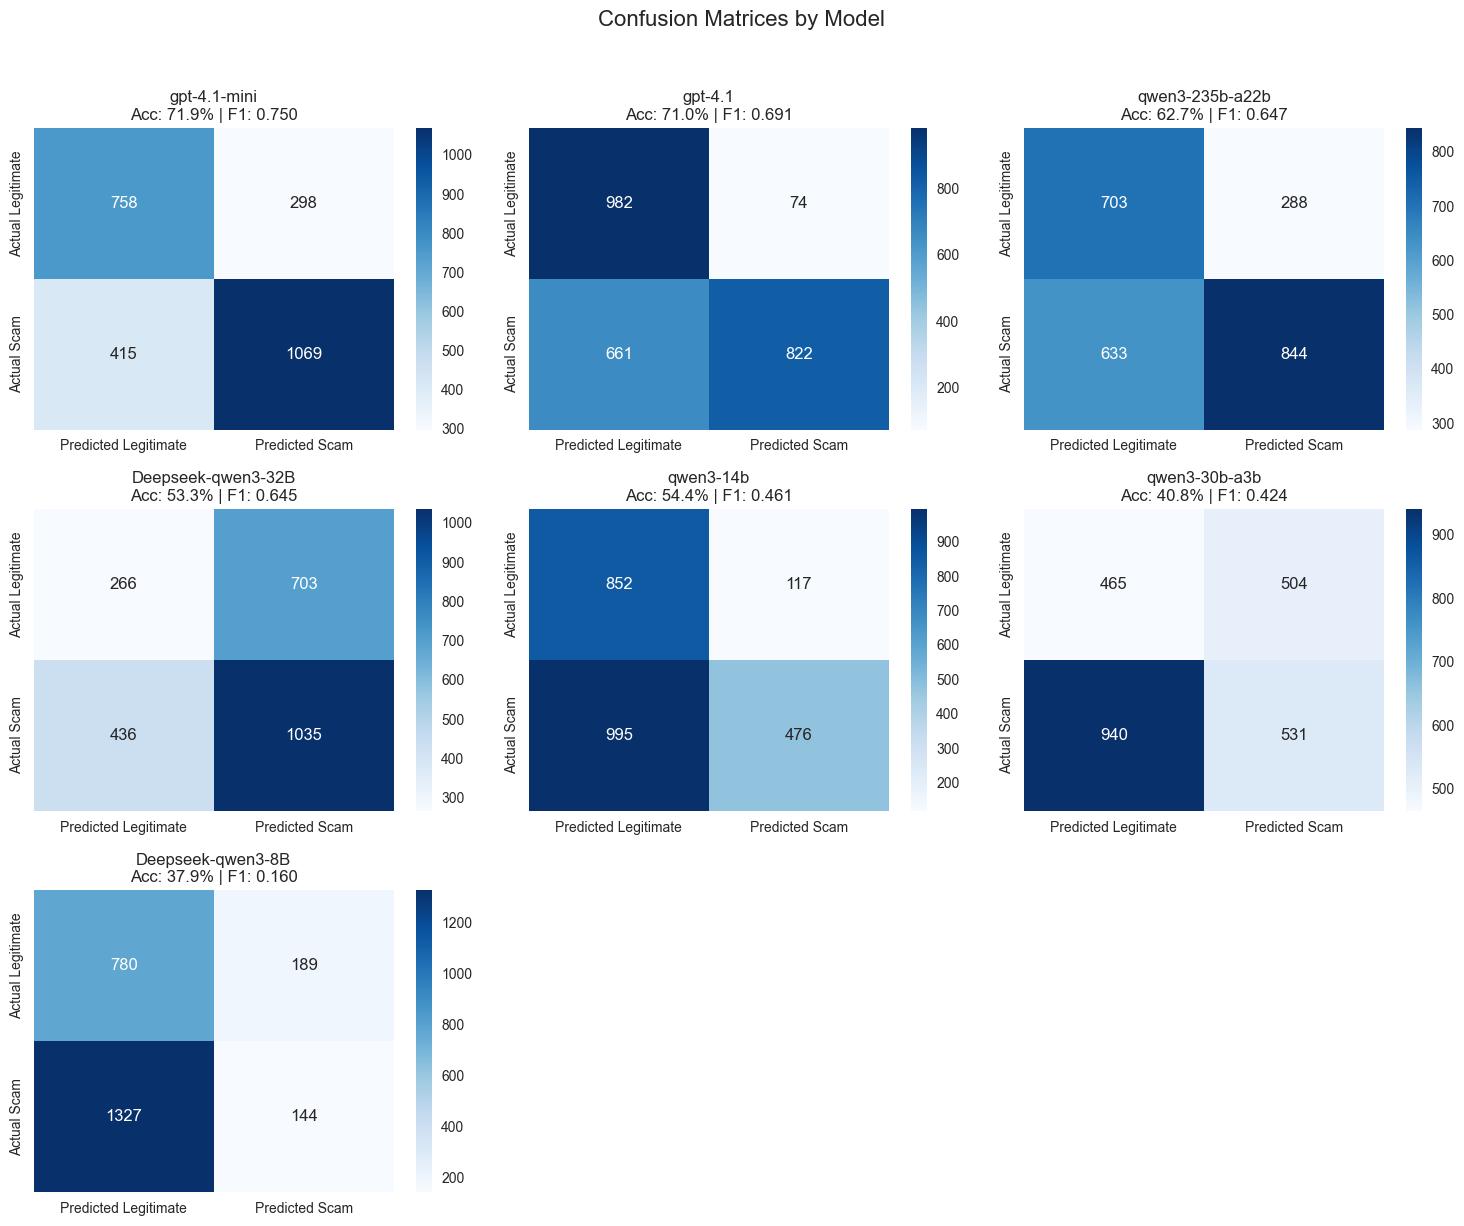

In [6]:
if not summary_df.empty and all_metrics:
    # Create confusion matrices for all models
    n_models = len(summary_df)
    cols = min(3, n_models)
    rows = (n_models + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_models == 1:
        axes = [axes]
    elif rows == 1 and cols > 1:
        axes = axes.reshape(1, -1)
    elif rows > 1 and cols == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, (_, model_row) in enumerate(summary_df.iterrows()):
        row = idx // cols
        col = idx % cols
        
        if rows > 1 and cols > 1:
            ax = axes[row, col]
        elif rows == 1:
            ax = axes[col] if cols > 1 else axes
        else:
            ax = axes[row] if rows > 1 else axes
        
        # Find corresponding metrics
        model_metrics = None
        for metrics in all_metrics:
            if metrics['display_name'] == model_row['Model']:
                model_metrics = metrics
                break
        
        if model_metrics:
            # Create confusion matrix array
            conf_matrix = np.array([
                [model_metrics['true_negatives'], model_metrics['false_positives']],
                [model_metrics['false_negatives'], model_metrics['true_positives']]
            ])
            
            # Plot heatmap
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                       xticklabels=['Predicted Legitimate', 'Predicted Scam'],
                       yticklabels=['Actual Legitimate', 'Actual Scam'])
            ax.set_title(f'{model_row["Model"]}\nAcc: {model_row["Accuracy"]:.1%} | F1: {model_row["F1 Score"]:.3f}')
    
    # Hide empty subplots
    for idx in range(n_models, rows * cols):
        row = idx // cols
        col = idx % cols
        if rows > 1 and cols > 1:
            axes[row, col].set_visible(False)
        elif rows == 1 and cols > 1:
            axes[col].set_visible(False)
        elif rows > 1 and cols == 1:
            axes[row].set_visible(False)
    
    plt.suptitle('Confusion Matrices by Model', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

else:
    print("No data available for confusion matrix analysis.")


In [7]:
if not summary_df.empty and not fair_summary_df.empty:
    print("DETAILED PERFORMANCE ANALYSIS")
    print("=" * 80)
    
    # FAIR COMPARISON ANALYSIS (Primary Results)
    print("\nFAIR COMPARISON RESULTS (Bias-Free Analysis)")
    print("=" * 60)
    
    fair_display_df = fair_summary_df[['Model', 'Fair_Accuracy', 'Fair_Precision', 'Fair_Recall', 'Fair_F1_Score', 'Fair_Specificity']].copy()
    fair_display_df.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity']
    
    # Best overall performer in fair comparison
    best_fair_f1_idx = fair_display_df['F1 Score'].idxmax()
    best_fair_model = fair_display_df.loc[best_fair_f1_idx]
    
    print("\nBEST OVERALL PERFORMER (Fair F1 Score)")
    print(f"Model: {best_fair_model['Model']}")
    print(f"F1 Score: {best_fair_model['F1 Score']:.3f}")
    print(f"Accuracy: {best_fair_model['Accuracy']:.3f} ({best_fair_model['Accuracy']:.1%})")
    print(f"Precision: {best_fair_model['Precision']:.3f}")
    print(f"Recall: {best_fair_model['Recall']:.3f}")
    print(f"Specificity: {best_fair_model['Specificity']:.3f}")
    
    # Fair comparison category leaders
    fair_categories = {
        'Best Accuracy': 'Accuracy',
        'Best Precision': 'Precision',
        'Best Recall': 'Recall',
        'Best Specificity': 'Specificity'
    }
    
    for category, metric in fair_categories.items():
        best_idx = fair_display_df[metric].idxmax()
        best_in_category = fair_display_df.loc[best_idx]
        print(f"\n{category.upper()} (Fair): {best_in_category['Model']}")
        print(f"   {metric}: {best_in_category[metric]:.3f}")
    
    # BIAS ANALYSIS: Compare Original vs Fair Rankings
    print("\nBIAS IMPACT ANALYSIS")
    print("=" * 40)
    
    # Calculate ranking changes
    ranking_changes = []
    for i, orig_model in enumerate(summary_df['Model']):
        orig_rank = i + 1
        # Find this model in fair comparison
        fair_rank = None
        for j, fair_model in enumerate(fair_display_df['Model']):
            if fair_model == orig_model:
                fair_rank = j + 1
                break
        
        if fair_rank:
            rank_change = orig_rank - fair_rank  # Positive = improved in fair comparison
            ranking_changes.append({
                'model': orig_model,
                'original_rank': orig_rank,
                'fair_rank': fair_rank,
                'rank_change': rank_change
            })
    
    # Sort by rank change
    ranking_changes.sort(key=lambda x: x['rank_change'], reverse=True)
    
    print("RANKING CHANGES (Original → Fair Comparison):")
    for change in ranking_changes:
        if change['rank_change'] > 0:
            direction = f"improved {change['rank_change']} positions"
        elif change['rank_change'] < 0:
            direction = f"dropped {abs(change['rank_change'])} positions"
        else:
            direction = "no change"
        
        print(f"  {change['model']}: #{change['original_rank']} → #{change['fair_rank']} ({direction})")
    
    # Performance delta analysis
    print("\nPERFORMANCE CHANGES (Fair - Original):")
    for model in summary_df['Model']:
        orig_f1 = summary_df[summary_df['Model'] == model]['F1 Score'].iloc[0]
        fair_row = fair_display_df[fair_display_df['Model'] == model]
        if not fair_row.empty:
            fair_f1 = fair_row['F1 Score'].iloc[0]
            delta = fair_f1 - orig_f1
            if abs(delta) > 0.01:  # Only show significant changes
                print(f"  {model}: {delta:+.3f} ({orig_f1:.3f} → {fair_f1:.3f})")
    
    # PROCESSING EFFICIENCY ANALYSIS
    print("\nPROCESSING EFFICIENCY ANALYSIS")
    print("=" * 45)
    
    # Calculate success rates and data loss
    for model in summary_df['Model']:
        orig_processed = summary_df[summary_df['Model'] == model]['Processed'].iloc[0]
        orig_failed = summary_df[summary_df['Model'] == model]['Failed'].iloc[0]
        orig_total = orig_processed + orig_failed
        
        fair_row = fair_summary_df[fair_summary_df['Model'] == model]
        if not fair_row.empty:
            fair_size = fair_row['Fair_Dataset_Size'].iloc[0]
            data_loss = orig_total - fair_size
            success_rate = orig_processed / orig_total if orig_total > 0 else 0
            
            print(f"{model}:")
            print(f"   Original Success Rate: {success_rate:.1%} ({orig_processed}/{orig_total})")
            print(f"   Fair Comparison Size: {fair_size:,} records")
            print(f"   Data Loss for Fair Comparison: {data_loss} records ({data_loss/orig_total:.1%})")
    
    # PRODUCTION RECOMMENDATIONS
    print("\nUNBIASED RECOMMENDATIONS")
    print("=" * 45)
    
    print("RECOMMENDED FOR PRODUCTION (Based on Fair Comparison):")
    print(f"   Best Overall: {best_fair_model['Model']} (F1: {best_fair_model['F1 Score']:.3f})")
    
    # Processing reliability
    summary_df_with_success = summary_df.copy()
    summary_df_with_success['Success_Rate'] = (summary_df_with_success['Processed'] / 
                                             (summary_df_with_success['Processed'] + summary_df_with_success['Failed']))
    best_reliability_idx = summary_df_with_success['Success_Rate'].idxmax()
    best_reliability = summary_df_with_success.loc[best_reliability_idx]
    
    print(f"   Most Reliable: {best_reliability['Model']} (Success: {best_reliability['Success_Rate']:.1%})")
    
    # Use case specific (fair comparison)
    best_fair_precision_idx = fair_display_df['Precision'].idxmax()
    best_fair_recall_idx = fair_display_df['Recall'].idxmax()
    fair_precision_model = fair_display_df.loc[best_fair_precision_idx]
    fair_recall_model = fair_display_df.loc[best_fair_recall_idx]
    
    print(f"   For Minimizing False Alarms: {fair_precision_model['Model']} (Precision: {fair_precision_model['Precision']:.3f})")
    print(f"   For Catching More Scams: {fair_recall_model['Model']} (Recall: {fair_recall_model['Recall']:.3f})")
    
    # Fair comparison performance tiers
    print("\nFAIR COMPARISON PERFORMANCE TIERS:")
    for i, (_, row) in enumerate(fair_display_df.iterrows()):
        print(f"   {row['Model']}: F1 = {row['F1 Score']:.3f}")
    
    # Dataset insights
    print("\nKEY INSIGHTS:")
    fair_f1_std = fair_display_df['F1 Score'].std()
    fair_avg_accuracy = fair_display_df['Accuracy'].mean()
    print(f"   • Fair Comparison Dataset: {len(safe_comparison_ids):,} records ({len(safe_comparison_ids)/2540:.1%} of total)")
    print(f"   • Average Fair Accuracy: {fair_avg_accuracy:.1%}")
    print(f"   • F1 Score Variance (Fair): σ = {fair_f1_std:.3f}")

elif not summary_df.empty:
    print("Fair comparison requires detailed evaluation results.")
    print("Only original (potentially biased) metrics are available.")
else:
    print("No data available for analysis.")


DETAILED PERFORMANCE ANALYSIS

FAIR COMPARISON RESULTS (Bias-Free Analysis)

BEST OVERALL PERFORMER (Fair F1 Score)
Model: gpt-4.1-mini
F1 Score: 0.752
Accuracy: 0.713 (71.3%)
Precision: 0.784
Recall: 0.722
Specificity: 0.699

BEST ACCURACY (Fair): gpt-4.1-mini
   Accuracy: 0.713

BEST PRECISION (Fair): gpt-4.1
   Precision: 0.919

BEST RECALL (Fair): gpt-4.1-mini
   Recall: 0.722

BEST SPECIFICITY (Fair): gpt-4.1
   Specificity: 0.926

BIAS IMPACT ANALYSIS
RANKING CHANGES (Original → Fair Comparison):
  gpt-4.1-mini: #1 → #1 (no change)
  gpt-4.1: #2 → #2 (no change)
  qwen3-235b-a22b: #3 → #3 (no change)
  Deepseek-qwen3-32B: #4 → #4 (no change)
  qwen3-14b: #5 → #5 (no change)
  qwen3-30b-a3b: #6 → #6 (no change)
  Deepseek-qwen3-8B: #7 → #7 (no change)

PERFORMANCE CHANGES (Fair - Original):

PROCESSING EFFICIENCY ANALYSIS
gpt-4.1-mini:
   Original Success Rate: 100.0% (2540/2540)
   Fair Comparison Size: 2,439 records
   Data Loss for Fair Comparison: 101 records (4.0%)
gpt-4.1:
 